In [1]:
import argparse
import copy
from tqdm import tqdm
import torch
from transformers import CLIPModel, CLIPTokenizer
from inverse_stable_diffusion import InversableStableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler, DDIMScheduler
import open_clip
from optim_utils import *
from io_utils import *
from image_utils import *
from watermark import *
import re
from diffusers import AutoPipelineForText2Image
from diffusers import AutoPipelineForImage2Image
import random
import os 


2024-08-14 12:28:34.755442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 12:28:34.789586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 12:28:34.798931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 12:28:34.834728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 12:28:35.788043: W tensorflow/compiler/tf2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]= "3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
print(device)

cuda


In [4]:
reference_model = None 
reference_model_pretrain = None 
model_path = "stabilityai/stable-diffusion-2-1-base"
channel_copy = 1 
hw_copy = 8 
fpr = 0.000001
num = 1000
user_number = 1000000
output_path = "/raid/home/ashhar21137/watermarking2/Gaussian-Shading/gs_watermarked_images_2"
gen_seed = 0 
num_inference_steps = 50 
guidance_scale = 7.5
image_length = 512
chacha = True
num_inversion_steps = 50

In [5]:
from types import SimpleNamespace


In [6]:
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_path, subfolder='scheduler')
pipe = InversableStableDiffusionPipeline.from_pretrained(
        model_path,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        revision='fp16',
)
pipe.safety_checker = None
pipe = pipe.to(device)

#reference model for CLIP Score
if reference_model is not None:
    ref_model, _, ref_clip_preprocess = open_clip.create_model_and_transforms(reference_model,
                                                                                pretrained=reference_model_pretrain,
                                                                                device=device)
    ref_tokenizer = open_clip.get_tokenizer(reference_model)

# dataset
# dataset, prompt_key = get_dataset(args)

# class for watermark
if chacha:
    watermark = Gaussian_Shading_chacha(channel_copy, hw_copy, fpr, user_number)
else:
    #a simple implement,
    watermark = Gaussian_Shading(channel_copy, hw_copy, fpr, user_number)


/raid/home/ashhar21137/anaconda3/envs/zodiac/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
init_latents_w = watermark.create_watermark_and_return_w()

In [8]:
import matplotlib.pyplot as plt
def visualize_tensor(tensor, name='./tmp.png'):
    channels = tensor.squeeze(0).cpu().numpy()
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    for i, ax in enumerate(axs):
        ax.imshow(channels[i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

    plt.savefig(name)
    plt.show()


/tmp/ipykernel_152724/3646859057.py:1: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/EmptyTensor.cpp:31.)
  init_latents_w_fft = torch.fft.fftshift(torch.fft.fft2(init_latents_w), dim=(-1, -2)).real


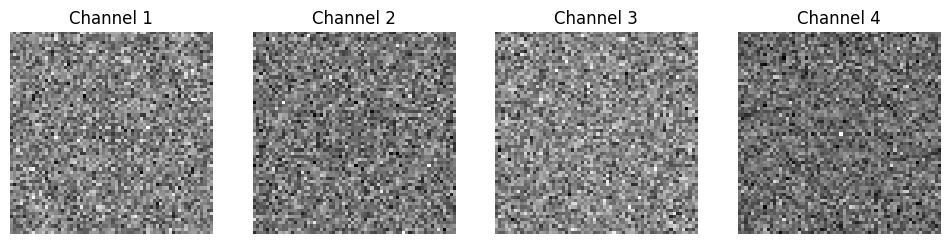

In [9]:
init_latents_w_fft = torch.fft.fftshift(torch.fft.fft2(init_latents_w), dim=(-1, -2)).real
visualize_tensor(init_latents_w_fft.detach().cpu(), name='./real.png')


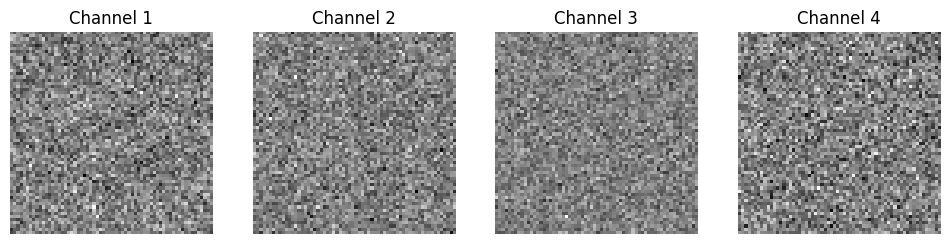

In [10]:
init_latents_w_fft = torch.fft.fftshift(torch.fft.fft2(init_latents_w), dim=(-1, -2)).imag
visualize_tensor(init_latents_w_fft.detach().cpu(), name='./imag.png')
